Source of data: https://data.stackexchange.com/stackoverflow/query/edit/960504  
SQL request: SELECT Id, Body, Title, Tags, LastActivityDate, Score FROM Posts WHERE LastActivityDate > '01/01/2016' AND Tags IS NOT NULL AND Score > 10

good ressource: [here](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)

01. <a href="#1.-Import-and-cleaning-data">Import and cleaning data</a>  
    1.1 <a href="#1.1-Tag-processing">Tag processing</a>  
    1.2 <a href="#1.2-Corpus-processing">Corpus processing</a>  
    1.3 <a href="#1.3-Feature-engineering">Feature engineering</a>  
02. <a href="#2.-Unsupervised-learning">Unsupervised learning</a>  
    2.1 <a href="#2.1-LDA:-LatentDirichletAllocation">LDA: LatentDirichletAllocation</a>  
    2.2 <a href="#2.2-NMF:-Negative-Matrix-Factorisation">NMF: Negative Matrix Factorisation</a>  
03. <a href="#3.-Supervised-learning">Supervised learning</a>



## 1. Import and cleaning data
The first cleaning consist mainly on removing some specific characters (":", "*", "[", ...) and html/xml tags.

In [1]:
# import data
import pandas as pd
import nltk   # Natural Language Toolkit

text = pd.read_csv("QueryResults.csv", index_col=0)
text_df = text.sample(10000)   # to limit processing time
text_df.head(5)

,Body,Title,Tags,LastActivityDate,Score
Id,,,,,
1241429,"<p>Once upon a time I bumped into <a href=""htt...",Blocking IO vs non-blocking IO; looking for go...,<events><blocking><nonblocking><io>,2018-06-26 09:22:41,42
2329460,"<p>In my reading on dynamic and static typing,...",Which languages are dynamically typed and comp...,<programming-languages><type-systems><dynamic-...,2017-01-12 16:59:53,36
1326570,<p>I want to hide any scrollbars from my <code...,How can I disable a browser or element scrollb...,<javascript><jquery><css><browser><scrollbar>,2018-01-11 16:16:25,51
10857393,"<p>I have these date and time fields, and I wa...",how to make label visible/invisible?,<javascript><html><label>,2018-07-04 08:56:26,15
531502,<p>Is it possible to build resources into a st...,VC++ resources in a static library,<visual-c++><resources><static-libraries>,2017-03-31 18:09:10,33


In [2]:
# Merge Body and Title columns
corpora = text_df.loc[:, "Title"] + text_df.loc[:, "Body"]
corpora.head()

Id
1241429     Blocking IO vs non-blocking IO; looking for go...
2329460     Which languages are dynamically typed and comp...
1326570     How can I disable a browser or element scrollb...
10857393    how to make label visible/invisible?<p>I have ...
531502      VC++ resources in a static library<p>Is it pos...
dtype: object

In [3]:
# clean text function
import re   # Regular expression library

def cleantext(raw_text):
    """clean raw text: 
           1. remove markups
           2. remove some special characters
           3. lower all"""
    
    #1. remove markups
    cleanr = re.compile('<.*?>')  
    cleantext = re.sub(cleanr, ' ', raw_text)
    
    #2. remove special characters
    element2remove = [r"\.\s", r'"', r"'", r"\!", r"\?", r"\,",
                      r"\:", "\(", "\)", "\n", "\*", "\]", "\[", "&nbsp;",
                      "&lt;", "\//", "=", "\{", "\}", "&gt;"]                   
    for e in element2remove:
        cleantext = re.sub(e, ' ', cleantext)
        
    #3. lower all (remove Capital letters)   
    cleantext = cleantext.lower() 
    
    return cleantext

In [4]:
corpora = corpora.apply(cleantext)
corpora.iloc[0]

'blocking io vs non-blocking io; looking for good articles once upon a time i bumped into  introduction to indy  article and can t stop thinking about blocking vs non-blocking io ever since then    looking for some good articles describing what are pros and cons of blocking io and non-blocking io and  how to design your application in each case  to get natural  easy to understand and easy to maintain code  would like to understand big picture..  '

### 1.1 Tag processing
In this section we will clean and explore the tag columns.

In [5]:
# clean tags
tags = text_df.loc[:, "Tags"]

def cleantags(tags):
    """clean raw tags"""
    #remove markups
    tags = tags.replace("><", ' ')
    tags = tags.replace("<", '')
    tags = tags.replace(">", '')
    tags = tags.lower()  # remove capital letters
    return tags

tags = tags.apply(cleantags)
tags.head()

Id
1241429                        events blocking nonblocking io
2329460     programming-languages type-systems dynamic-typ...
1326570               javascript jquery css browser scrollbar
10857393                                javascript html label
531502                  visual-c++ resources static-libraries
Name: Tags, dtype: object

In [6]:
# lists of tags
all_tags = []       # list of all tags
primary_tags = []   # list of first tags (= the most relevent for each docs)
document_tags =  [] # "list of list" of tags for each document
for line in tags:
    tag = line.split()
    primary_tags.append(tag[0])
    document_tags.append(tag)
    for w in tag:
        all_tags.append(w)
        
primary_tags = nltk.FreqDist(primary_tags)   # ~ dict type
all_tags = nltk.FreqDist(all_tags)           # ~ dict type

In [7]:
df_1 = pd.DataFrame(all_tags.most_common(), columns=["tags","freq_all"])
cum_sum = df_1["freq_all"].cumsum()  #


In [8]:
cum_sum.tail()

5471    30387
5472    30388
5473    30389
5474    30390
5475    30391
Name: freq_all, dtype: int64

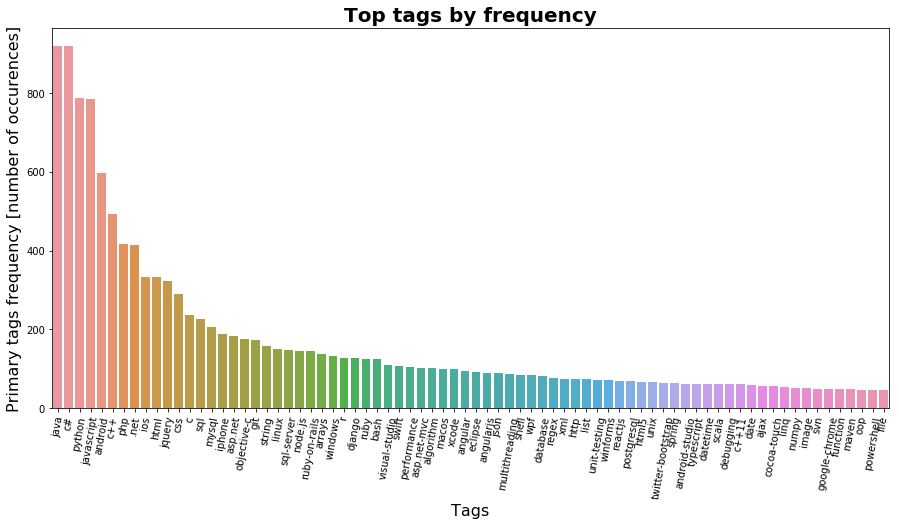

In [55]:
# most common tags plot
import matplotlib.pyplot as plt
import seaborn as sns

# inputs
top_n = 75
df_1 = pd.DataFrame(all_tags.most_common(), columns=["tags","freq_all"])
df_2 = pd.DataFrame(primary_tags.most_common(), columns=["tags","freq_primary"])  
df = pd.merge(df_1, df_2, how="left" )

# plot
plt.figure(figsize=(15,7))
plt.title("Top tags by frequency", fontweight="bold", size=20)
sns.barplot(y= "freq_all", x= "tags", data= df.loc[0:top_n, :], label="Total")
plt.xticks(rotation=80, size=10)
plt.xlabel("Tags", size=16)
plt.ylabel("Primary tags frequency [number of occurences]", size=16)
plt.show()

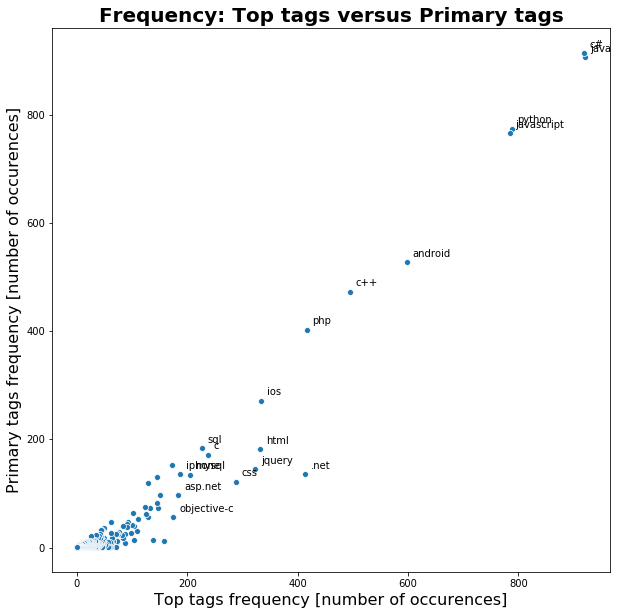

In [10]:
# relation in-beetwee frequency on top tags and primary tags 
plt.figure(figsize=(10, 10))
plt.title("Frequency: Top tags versus Primary tags", fontweight="bold", size = 20)
sns.scatterplot(x="freq_all", y="freq_primary", data=df)
# plt.scatter(x="freq_all", y="freq_primary", data=df, label="Total",marker="+", s=75)

for i in range(0,18):
    plt.annotate(df.loc[i,"tags"],
                 (df.loc[i,"freq_all"]+10, df.loc[i,"freq_primary"]+10),
                 size=10)

plt.xlabel("Top tags frequency [number of occurences]", size=16)
plt.ylabel("Primary tags frequency [number of occurences]", size=16)
plt.show()  

Clear correlation from primary tags freq and all tags frequency. For the rest we will select the top 150 tags (as it decreases very slowly in this area)

In [11]:
# creaton of top tag list
top_n = 150
top_t = list(df.loc[0:top_n-1, "tags"])

# Extra infos
count_top = df.loc[0:top_n, "freq_all"].sum()
count_all = df["freq_all"].sum()
fract_t = round(top_n/len(df),2)*100
fract_v = round(count_top/count_all,3)*100
print("The top {} tags ({}% of the tag population)\
represent {}% in term of volume/occurences.".format(top_n, fract_t, fract_v))

The top 150 tags (3.0% of the tag population)represent 50.5% in term of volume/occurences.


### 1.2 Corpus processing
In this section we will clean and explore the corpus (body columns).

In [12]:
# Part of Speech Tagging
import nltk
from nltk.tokenize import PunktSentenceTokenizer   # already train sentence tokensier
from nltk.corpus import stopwords

# --------------------------------------------------------------------------------

# standard stopwords list from nltk library
stopwords = set(stopwords.words("english"))

# updated with some specific words
stopwords.update(["p","/p","way","=","something", "anyone", "possible", "good", "example",
                 "question", "solution", "able", "different", "first", 'following',
                  "anything", 'help', 'thing','sure', 'many', 'lot', 'much', "several",
                  "wrong", "right", "idea", "easy", "everything", "difference", "|",
                 "certain", "kind", "great", "nothing", "answer", "please", "little",
                 "/", "\&gt;", "+", "..", "\=&gt;", "specific", "code", "new", "name",
                 "error", "use", "file", "work", "value"])

def process_content(text_body, stopwords):
    """
    Tokenize a text ('text_body') by words and keep the nouns(NN) and adjective or numeral, ordinal (JJ) 
    then remove stop words ('stopwords').
    Inputs:
        - text_body: string
        - stopwords: list of string
    Outputs:
        - return a list of words selection
        """
    
    tokenizer = PunktSentenceTokenizer()
    tokenized = tokenizer.tokenize(text_body)
    all_nouns = []   
    for sentence in tokenized:
        # words = nltk.word_tokenize(sentence)
        words = sentence.split()
        # get the information of the word (noune, verb,etc..)
        tagged = nltk.pos_tag(words)  
        for w in tagged:
            if ((w[1] == "NN")or(w[1] == "JJ")) and (w[0] not in stopwords):
                all_nouns.append(w[0])
    return all_nouns

In [13]:
# list of processed words
all_words = []
for body in corpora:
    tokenized_body = process_content(body, stopwords)
    for w in tokenized_body:
        all_words.append(w)
all_words = nltk.FreqDist(all_words)   # ~ dict type
print("{} words have been extracted".format(len(all_words)))

57126 words have been extracted


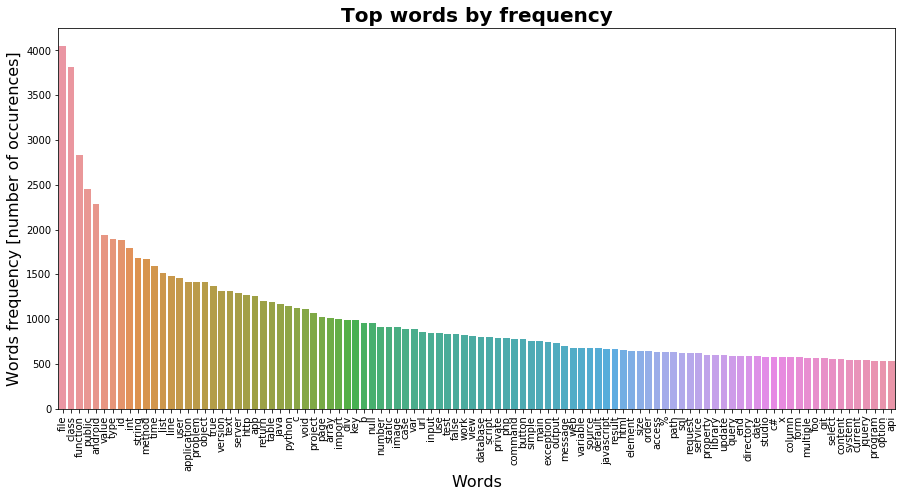

In [14]:
# most frequent words
# inputs
top_n = 100
df = pd.DataFrame(all_words.most_common(top_n), columns=["words","freq"])

# plot
plt.figure(figsize=(15,7))
plt.title("Top words by frequency", fontweight="bold", size=20)
plt.xticks(rotation=90, size=10)
sns.barplot(y="freq", x="words", data=df.loc[0:top_n, :], label="Total");
plt.xlabel("Words", size=16)
plt.ylabel("Words frequency [number of occurences]", size=16)
plt.show()

In [15]:
all_words.most_common(10)

[('file', 4047),
 ('class', 3812),
 ('function', 2837),
 ('public', 2456),
 ('android', 2291),
 ('value', 1936),
 ('type', 1890),
 ('id', 1883),
 ('int', 1795),
 ('string', 1684),
 ('method', 1674),
 ('time', 1597),
 ('list', 1519),
 ('line', 1481),
 ('user', 1454)]

In [16]:
# Build vocabulary dict based on the most fequent words
number_of_top_words = 500
top_w = list(zip(*all_words.most_common(number_of_top_words)))[0]

# add top tags to this list
top_w = set(list(top_w) + list(top_t))
len(top_w)

593

### 1.3 Feature engineering
In this section, based on our corpus and list of most commons words, we will create new features that can be used as input for our models:
- TF Term Frequency table: for each documents (row) we will compute the frequency of the most frequent words (columns)
- TF-IDF Term Frequency - Inverse Document Frequency: The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. This help to reduce the importance of the very commons words. More information [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)  
First, to build those tables we need to select wich feature/words that would be used as input. For this we will run several times:
    1. Create a vocabulary list
    2. Create TF and TF-IDF Table 
    3. Run the LDA model
    4. Model score evaluation  

On each loops we will change the initial vocabulary list, and see the impact on the final scoring.  
    

 

In [17]:
# formating input for the vocabulaty list
def vocabulary(all_words, all_tags, Nw, Nt):
    """ return a dictionary of vocabulary. It merges the top Nw words from all_words
    with the top Nt from all_tags. This format is needed as input of nltk vectoriser"""
    top_w = list(zip(*all_words.most_common(Nw)))[0]
    top_t = list(zip(*all_tags.most_common(Nt)))[0]
    # add top tags to this list
    top_w = set(list(top_w) + list(top_t))

    # formating: list of for for vectorized input
    return dict(zip(top_w, range(0, len(top_w))))

In [45]:
document_tags

[['events', 'blocking', 'nonblocking', 'io'],
 ['programming-languages', 'type-systems', 'dynamic-typing', 'static-typing'],
 ['javascript', 'jquery', 'css', 'browser', 'scrollbar'],
 ['javascript', 'html', 'label'],
 ['visual-c++', 'resources', 'static-libraries'],
 ['c#', 'datetime', '.net-2.0'],
 ['jquery'],
 ['regex', 'shell', 'curl'],
 ['c#', 'browser', 'desktop-application'],
 ['objective-c', 'cocoa-touch', 'cocoa', 'nsarray', 'deep-copy'],
 ['c++', 'gcc'],
 ['c', 'stack', 'malloc', 'allocation', 'alloca'],
 ['javascript', 'onkeydown'],
 ['c++', 'com'],
 ['android', 'android-activity', 'android-broadcast'],
 ['asp.net-mvc', 'webforms'],
 ['android'],
 ['ios', 'http', 'url', 'uiwebview', 'hyperlink'],
 ['java', 'multithreading', 'executorservice', 'shutdown'],
 ['android', 'ios', 'html5', 'svg', 'mobile-website'],
 ['php', 'regex', 'string'],
 ['java', 'android', 'android-studio', 'java-8', 'android-studio-2.2'],
 ['svn', 'tortoisesvn', 'branch'],
 ['javascript', 'three.js', 'webg

In [44]:
# Functions used for the scoring evaluations
# Note: The words return here are the top X based on the number of occurence
# could be better the have the top percentage compare to the complete Corpus

def display_topics2(model, feature_names, no_top_words=25):
    """create a panda data frame of the top words present in each topics.
    inputs: 
        - model: fitted model, from where we will extract the results (numeric)
        - feature_names: list of string (words used in the model)
        - no_top_words: int, the number of top words per topics we want to extract
    output:
        - Pandas data frame 
        """
    word_dict = {};
    for topic_idx, topic in enumerate(model.components_):
        word_dict["Topic%d" % (topic_idx)] = [feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(word_dict).T

def topic_score(model, vectorized_input, feature_names, top_t, document_tags):
    """The scoring function is design for the purpose off assessing the quality of the predicted tag
    in the context of tags suggestion. For tis we will compute the ratio of real tags words present
    in the predicted list of tags.
    Inputs: 
        - model: fitted sklearn model, from where we will extract the results (numeric).
        - vectorized_input: tf or tf-idf vectorized input
        - feature_names: list of string (words used in the model)
        - document_tags: list of list of str, each document has a list of real tags
        - top_t: list of str, all existing tags 
    Output:
        - score: float, [0:1]
        """

    # topic df ----------------------------------------------------------------------------
    topic_df = display_topics2(model, feature_names, no_top_words=25)
    # associate each topic with a list of tags
    topics_kwords_df = (topic_df.isin(top_t)*topic_df).T
    topic2tags_d = {}
    tags_per_topic = []
    for topic in topics_kwords_df:
        tag_list = []
        for e in topics_kwords_df.loc[:, topic]:
            if e is not "":
                tag_list.append(e)
        topic2tags_d[topic] = tag_list

    # Create Document Vs Topic Matrix ------------------------------------------------------
    model_output = model.transform(vectorized_input)
    # column names
    topicnames = ["Topic" + str(i) for i in range(model.components_.shape[0])]
    # index names
    docnames = ["Post" + str(i) for i in range(vectorized_input.shape[0])]
    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(model_output, 2), columns=topicnames, index=docnames)

    # Tag prediction -----------------------------------------------------------------------
    treshold = 0.20
    tag_pred = []
    for post in df_document_topic.index:
        tags_post = []
        mask = df_document_topic.loc[post, :] >= treshold
        topic_pred = list(df_document_topic.loc[post, mask].index)
        for topic in topic_pred:
            tags_post = tags_post + topic2tags_d[topic].copy()
        tag_pred.append(tags_post)

    # Scoring ----------------------------------------------------------------------------------
    tag_score = []   # list of score for each document (score = ratio of real tags present in the prediction)
    for i in range(len(document_tags)):
        score = 0 
        count_e = 0
        for e in document_tags[i]:
            if e in tag_pred[i]:
                score = score + 1
            count_e = count_e + 1
        tag_score.append(round(score/count_e,2))

    return sum(tag_score)/len(tag_score)

In [76]:
# Manual grid seach on the composition of vocabulary

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
import numpy as np

n_top_w = [1,50,100,300]
n_top_t = [100,150,200,300]

grid_score_lda_tf = pd.DataFrame(0, index = n_top_w, columns= n_top_t) 
grid_score_lda_tf.index.name = "n_top_w"
grid_score_lda_tf.columns.name = "n_top_t"
grid_score_lda_tfidf = grid_score_lda_tf.copy()
grid_score_nmf_tf = grid_score_lda_tf.copy()
grid_score_tfidf = grid_score_lda_tf.copy()
grid_score_nmt_tfidf = grid_score_lda_tf.copy()


for w in n_top_w:
    for t in n_top_t:

        voca = vocabulary(all_words, all_tags, w, t)
        
        # tf
        tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, 
                                        vocabulary=voca,
                                        stop_words=stopwords)
        tf = tf_vectorizer.fit_transform(corpora)

        # tf-idf
        from sklearn.feature_extraction.text import TfidfVectorizer
        tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                           vocabulary=voca,
                                           stop_words=stopwords)
        tfidf = tfidf_vectorizer.fit_transform(corpora)

        # extraction of feature names
        feature_names = tf_vectorizer.get_feature_names()     
        
        no_topics = 25  # hyperparametre (a tester)
        # Run LDA on tf
        lda_tf = LatentDirichletAllocation(n_topics=no_topics, 
                                            random_state=1).fit(tf)
        grid_score_lda_tf.loc[w, t ] = topic_score(lda_tf, tf, feature_names, top_t)

        # Run LDA on tfidf
        lda_tfidf = LatentDirichletAllocation(n_topics=no_topics, 
                                            random_state=1).fit(tfidf)
        grid_score_lda_tfidf.loc[w, t ] = topic_score(lda_tfidf, tfidf, feature_names, top_t)
        
        # Run NMF on tf
        nmf_tf = NMF(n_components=no_topics, 
                     random_state=1, 
                     init='nndsvd').fit(tf)
        grid_score_nmf_tf.loc[w, t ] = topic_score(nmf_tf, tf, feature_names, top_t)
        
        # Run NMF on tfidf
        nmf_tfidf = NMF(n_components=no_topics, 
                        random_state=1, 
                        init='nndsvd').fit(tfidf)
        grid_score_nmt_tfidf.loc[w, t ] = topic_score(nmf_tfidf, tfidf, feature_names, top_t)
             
        print("loops W=",w,"  T=",t)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 1   T= 100


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 1   T= 150


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 1   T= 200


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 1   T= 300


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 50   T= 100


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 50   T= 150


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 50   T= 200


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 50   T= 300


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 100   T= 100


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 100   T= 150


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 100   T= 200


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 100   T= 300


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 300   T= 100


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 300   T= 150


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 300   T= 200


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 300   T= 300


In [79]:
grid_score_lda_tf

n_top_t,100,150,200,300
n_top_w,,,,
1,0.281971,0.293587,0.288465,0.267990
50,0.231829,0.241924,0.250867,0.234055
100,0.202075,0.230225,0.238934,0.231737
300,0.200625,0.193501,0.201804,0.209789


In [80]:
grid_score_lda_tfidf

n_top_t,100,150,200,300
n_top_w,,,,
1,0.274717,0.294396,0.288836,0.264009
50,0.245658,0.266458,0.266104,0.245182
100,0.232528,0.250424,0.256527,0.243066
300,0.220102,0.220815,0.226201,0.231514


In [82]:
grid_score_nmt_tfidf

n_top_t,100,150,200,300
n_top_w,,,,
1,0.111092,0.087007,0.088413,0.067507
50,0.024171,0.032613,0.025317,0.038263
100,0.026349,0.028783,0.030452,0.031888
300,0.016221,0.021647,0.021730,0.020335


In [84]:
grid_score_nmf_tf

n_top_t,100,150,200,300
n_top_w,,,,
1,0.096497,0.101115,0.093115,0.081130
50,0.069998,0.070063,0.070374,0.061293
100,0.056009,0.057478,0.056222,0.051603
300,0.048122,0.049860,0.048501,0.047175


The best score is obtain when the vocabulary input list is a combinaison of the top 1 words and the top 150 tags. It is quite instinctive that the chance of getting a correct tags is better if from the start, we select only the tags words as feature.
However here, we might also want the futur tag recommendation engine to be able to also produce new tags (IT world is changing fast). So even if it degrade a little bit our final quality we would introduce the 50 top words from the corpus. The Best model using the standard parameters is LDA combined with Tf-idf table. Note that NMF might perform better if we tune the parameters. However for simplicity, we will keep the LDA model with tfidf and try to optimise it.

In [100]:
# LDA TF-idf with previous choices

voca = vocabulary(all_words, all_tags, 50, 150)

# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   vocabulary=voca,
                                   stop_words=stopwords)
tfidf = tfidf_vectorizer.fit_transform(corpora)

# extraction of feature names
feature_names = tfidf_vectorizer.get_feature_names()  

# Run LDA on tfidf
lda_tfidf = LatentDirichletAllocation(n_topics=no_topics, 
                                random_state=0).fit(tfidf)

# print some metrics
topic_score(lda_tfidf, tfidf, feature_names, top_t)
data_dense = tfidf.todense()   # to compute sparsity (Percentage of Non-Zero cells)
print("LDA with tfidf---------------------------------------------------------")
print("tags prediction hit rate:", topic_score(lda_tfidf, tfidf, feature_names, top_t))
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")
print("Log Likelihood: ", round(lda_tfidf.score(tfidf),0))
print("Perplexity: ", round(lda_tfidf.perplexity(tfidf),0))

# top 10 words in each topics
display_topics2(lda_tfidf, feature_names, no_top_words=10)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LDA with tfidf---------------------------------------------------------
tags prediction hit rate: 0.2681979999999976
Sparsicity:  2.7726063829787235 %
Log Likelihood:  -111550.0
Perplexity:  471.0


,0,1,2,3,4,5,6,7,8,9
Topic0,text,php,work,file,use,line,function,problem,user,server
Topic1,image,ruby,perl,file,use,url,method,problem,work,http
Topic2,python,line,file,import,lambda,use,function,string,list,return
Topic3,project,true,case,false,validation,gradle,use,return,file,work
Topic4,number,arrays,dataframe,excel,array,testing,pandas,use,value,function
Topic5,list,api,linq,rest,use,firebase,id,user,time,go
Topic6,table,sql,server,mysql,database,oracle,id,use,user,key
Topic7,java,xml,performance,file,unix,use,parsing,application,value,method
Topic8,file,test,linux,bash,shell,csv,use,testing,line,time
Topic9,var,function,powershell,vim,ajax,math,ssh,javascript,file,jquery


## 3.LDA: LatentDirichletAllocation

In [101]:
# plot with PyLDAvis library
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tfidf, tfidf, tfidf_vectorizer, mds='tsne')
panel

C:\Users\ben\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
11     -57.308010  140.267166       1        1  8.312389
23     153.940842   76.285416       2        1  4.991964
24      28.337082 -151.835327       3        1  4.937293
6       17.022650  169.856949       4        1  4.916049
10    -114.324760   10.747197       5        1  4.805073
8      -54.205055   66.896614       6        1  4.556418
17       3.996641  -28.811985       7        1  4.464218
15    -120.700363   85.203125       8        1  4.131110
22      59.342785   -5.700825       9        1  4.036549
16      63.499603  117.459183      10        1  4.036216
12      -5.668248  -92.897270      11        1  4.019619
3      -59.195915  -53.883472      12        1  3.892354
2      119.058784   19.826763      13        1  3.829146
20     124.058479  143.143280      14        1  3.760103
0       70.220169   57.809772      15        1  3.722305
9       10.837688   35.213009      16        1  3.557540
5      -46.461567    6.828174      17        1  3.476768
7      167.595230  -81.362228      18        1  3.408828
19     184.798508   -0.763674      19        1  3.396419
18     111.346809  -44.667103      20        1  3.267698
14     -65.582100 -129.222458      21        1  3.000776
13       2.619050   96.262489      22        1  2.975476
4     -126.315781  -62.749660      23        1  2.907248
21      99.984909 -123.764847      24        1  2.838253
1       53.915546  -72.793648      25        1  2.760187, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
35    Default  352.000000            java  352.000000  30.0000  30.0000
143   Default  303.000000          python  303.000000  29.0000  29.0000
161   Default  278.000000         android  278.000000  28.0000  28.0000
101   Default  224.000000           image  224.000000  27.0000  27.0000
62    Default  312.000000            list  312.000000  26.0000  26.0000
64    Default  234.000000          number  234.000000  25.0000  25.0000
92    Default  427.000000          string  427.000000  24.0000  24.0000
14    Default  287.000000            text  287.000000  23.0000  23.0000
49    Default  210.000000         windows  210.000000  22.0000  22.0000
58    Default  213.000000           table  213.000000  21.0000  21.0000
0     Default  196.000000             php  196.000000  20.0000  20.0000
70    Default  408.000000        function  408.000000  19.0000  19.0000
57    Default  243.000000             int  243.000000  18.0000  18.0000
98    Default  180.000000             div  180.000000  17.0000  17.0000
135   Default  150.000000             git  150.000000  16.0000  16.0000
80    Default  562.000000            file  562.000000  15.0000  15.0000
32    Default  165.000000             sql  165.000000  14.0000  14.0000
7     Default  204.000000             var  204.000000  13.0000  13.0000
144   Default  146.000000            date  146.000000  12.0000  12.0000
176   Default  170.000000        database  170.000000  11.0000  11.0000
183   Default  266.000000          object  266.000000  10.0000  10.0000
118   Default  257.000000             app  257.000000   9.0000   9.0000
87    Default  149.000000          static  149.000000   8.0000   8.0000
69    Default  247.000000            line  247.000000   7.0000   7.0000
53    Default  207.000000           array  207.000000   6.0000   6.0000
109   Default  101.000000          django  101.000000   5.0000   5.0000
90    Default  102.000000            ruby  102.000000   4.0000   4.0000
157   Default  164.000000      javascript  164.000000   3.0000   3.0000
168   Default  233.000000         project  233.000000   2.0000   2.0000
15    Default  159.000000             url  159.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
8     Topic25    0.049298  android-studio 

Topics are well clusterised with very similar size. But we can see that some topics are stil merge as Java and xml, Ubuntu and dokers.

it is interesting to see that LDA on tf vectorisation seems to have more "homogenous" group size compare to LDA with tfidf. 

In [102]:
import numpy as np

# Create Document - Topic Matrix
lda_output = lda_tf.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_tf.n_topics)]

# index names
docnames = ["Post" + str(i) for i in range(tf.shape[0])]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
# dominant_topic = np.argmax(df_document_topic.values, axis=1)
# df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24
Post0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.49,0,0,0,0,0,0,0.43,0,0,0,0
Post1,0.01,0.01,0.49,0.01,0.01,0.17,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.19,0.01,0.01,0.01,0.01,0.01
Post2,0,0,0,0,0,0,0,0,0.38,0,0,0,0,0,0,0,0,0.24,0,0,0,0,0,0.29,0
Post3,0,0.13,0.08,0.01,0.14,0.04,0,0.06,0,0,0.08,0,0,0,0,0.04,0,0.23,0,0.01,0,0,0,0.17,0
Post4,0,0,0,0,0,0.21,0,0,0,0,0,0,0,0,0,0,0,0,0.59,0,0,0,0,0.11,0
Post5,0,0,0.74,0,0,0,0,0,0,0,0,0,0.13,0,0,0,0,0,0.09,0,0,0,0,0,0
Post6,0,0,0,0,0,0,0,0,0.13,0,0,0,0.11,0,0.13,0,0,0.48,0,0,0,0,0,0.11,0
Post7,0,0.09,0,0.23,0,0,0,0.12,0,0,0,0,0,0,0,0.28,0,0,0,0,0,0,0.24,0,0
Post8,0,0,0,0,0,0,0,0,0,0,0,0,0,0.23,0,0,0,0.35,0,0,0,0,0.34,0,0
Post9,0,0.05,0,0,0.3,0,0,0,0,0.1,0,0,0,0,0,0,0,0,0.26,0.25,0,0,0,0,0


In [103]:
# Manual Grid search, using our "tag hit rate" as scoring metric.

# values to test
topic_word_p = [0, 0.1, 0.25]  # for topic_word_prior parameter
doc_topic_p = [0, 0.1, 0.25]   # for doc_topic_prior parameter

# scoring empty dataFrame
grid_score = pd.DataFrame(0, index = topic_word_p, columns= doc_topic_p) 
grid_score.index.name = "topic_word_prior"
grid_score.columns.name = "doc_topic_prior"

# run the scoring calculation
for a in topic_word_p:
    for l1 in doc_topic_p:
        lda_tfidf = LatentDirichletAllocation(n_topics=no_topics, 
                                    topic_word_prior=a,   # high beta-value means that each topic is likely to contain a mixture of most of the words
                                    doc_topic_prior=l1,  # high alpha-value means that each document is likely to contain a mixture of most of the topic
                                    max_iter=50, 
                                    learning_method='online', 
                                    learning_offset=50.,
                                    random_state=0).fit(tfidf)
        grid_score.loc[a, l1] = topic_score(lda_tfidf, tfidf, feature_names, top_t)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:679: RuntimeWarning: invalid value encountered in multiply
  score = np.sum((prior - distr) * dirichlet_distr)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:680: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(distr) - gammaln(prior))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:681: RuntimeWarning: invalid value encountered in double_scalars
  score += np.sum(gammaln(prior * size) - gammaln(np.sum(distr, 1)))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWar

In [104]:
grid_score

doc_topic_prior,0.0,0.1,0.25
topic_word_prior,,,
0.00,0.281760,0.201726,0.016777
0.10,0.278556,0.208160,0.015744
0.25,0.279211,0.211822,0.014206


In [106]:
# Let's run on n_components and learning_decay
n_components = [20, 25, 30] 
learning_decay = [0.5, 0.7, 0.9]

grid_score = pd.DataFrame(0, index = n_components, columns= learning_decay) 
grid_score.index.name = "n_components"
grid_score.columns.name = "learning_decay"

for a in n_components:
    for l1 in learning_decay:
        lda_tfidf = LatentDirichletAllocation(n_components=a,
                                        learning_decay=l1,
                                        topic_word_prior=0.0,   # high beta-value means that each topic is likely to contain a mixture of most of the words
                                        doc_topic_prior=0.0,  # high alpha-value means that each document is likely to contain a mixture of most of the topic
                                        max_iter=50, 
                                        learning_method='online', 
                                        learning_offset=50.,
                                        random_state=0).fit(tfidf)
        grid_score.loc[a, l1] = topic_score(lda_tfidf, tfidf, feature_names, top_t)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:679: RuntimeWarning: invalid value encountered in multiply
  score = np.sum((prior - distr) * dirichlet_distr)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:680: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(distr) - gammaln(prior))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:681: RuntimeWarning: invalid value encountered in double_scalars
  score += np.sum(gammaln(prior * size) - gammaln(np.sum(distr, 1)))


In [107]:
grid_score

learning_decay,0.5,0.7,0.9
n_components,,,
20,0.274796,0.281214,0.273697
25,0.282306,0.281760,0.281556
30,0.281239,0.281670,0.276941


In [110]:
# Final Model

lda_tfidf = LatentDirichletAllocation(n_components=25,
                                    learning_decay=0.5,
                                    topic_word_prior=0.1,   # high beta-value means that each topic is likely to contain a mixture of most of the words
                                    doc_topic_prior=0.1,  # high alpha-value means that each document is likely to contain a mixture of most of the topic
                                    max_iter=50, 
                                    learning_method='online', 
                                    learning_offset=50.,
                                    random_state=0).fit(tfidf)

In [111]:
# plot with PyLDAvis library
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tfidf, tfidf, tfidf_vectorizer, mds='tsne')
panel

C:\Users\ben\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
0       29.442093  -74.715141       1        1  6.779561
3       19.003693   98.158394       2        1  5.479803
9      108.896309  -50.432259       3        1  5.256125
16    -127.626152  -15.185468       4        1  5.202128
2     -101.463112   34.860767       5        1  4.785882
19      -3.602908   16.265209       6        1  4.602897
15      61.146866  -40.097832       7        1  4.563405
7      -25.431633 -143.910858       8        1  4.503370
14    -107.624870  -67.964088       9        1  4.364906
21      29.039188   47.422489      10        1  4.070787
20     -51.672684   25.632126      11        1  3.915048
1       53.091106    7.718464      12        1  3.915000
6      102.762558    5.693677      13        1  3.883929
18      18.770805  -21.745804      14        1  3.796031
5      -19.339237  -95.528183      15        1  3.730453
10     -56.499191  -61.211792      16        1  3.714754
8       -9.972327  -52.963757      17        1  3.522956
22      78.090065   59.083492      18        1  3.425045
24     -66.653343   80.436874      19        1  3.395172
11     -19.586102   63.213531      20        1  3.226965
17      76.375000  -96.894043      21        1  2.932769
12     -77.940239  -17.545507      22        1  2.872338
23     -73.490440 -111.154823      23        1  2.841437
4      -32.717228  -16.965618      24        1  2.806302
13      28.900101 -125.608551      25        1  2.412938, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
162   Default  413.000000           test  413.000000  30.0000  30.0000
53    Default  294.000000          array  294.000000  29.0000  29.0000
94    Default  270.000000           null  270.000000  28.0000  28.0000
186   Default  238.000000            css  238.000000  27.0000  27.0000
118   Default  283.000000            app  283.000000  26.0000  26.0000
172   Default  303.000000    application  303.000000  25.0000  25.0000
14    Default  280.000000           text  280.000000  24.0000  24.0000
0     Default  224.000000            php  224.000000  23.0000  23.0000
178   Default  281.000000           http  281.000000  22.0000  22.0000
92    Default  357.000000         string  357.000000  21.0000  21.0000
58    Default  226.000000          table  226.000000  20.0000  20.0000
170   Default  213.000000            key  213.000000  19.0000  19.0000
143   Default  236.000000         python  236.000000  18.0000  18.0000
11    Default  275.000000             id  275.000000  17.0000  17.0000
62    Default  267.000000           list  267.000000  16.0000  16.0000
15    Default  200.000000            url  200.000000  15.0000  15.0000
35    Default  270.000000           java  270.000000  14.0000  14.0000
51    Default  194.000000      exception  194.000000  13.0000  13.0000
78    Default  336.000000          class  336.000000  12.0000  12.0000
87    Default  202.000000         static  202.000000  11.0000  11.0000
184   Default  188.000000            api  188.000000  10.0000  10.0000
61    Default  275.000000         server  275.000000   9.0000   9.0000
47    Default  161.000000     powershell  161.000000   8.0000   8.0000
80    Default  444.000000           file  444.000000   7.0000   7.0000
70    Default  336.000000       function  336.000000   6.0000   6.0000
43    Default  218.000000           page  218.000000   5.0000   5.0000
161   Default  215.000000        android  215.000000   4.0000   4.0000
56    Default  166.000000      variables  166.000000   3.0000   3.0000
101   Default  176.000000          image  176.000000   2.0000   2.0000
44    Default  169.000000          input  169.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
54    Topic25    0.474514   apache-spark    3.163259   1.8273  -6.8260
77  

## 5. supervized_model

In [83]:
# Initialisation (en faire une fonction)

train_y = pd.DataFrame(0, index=text_df.index, columns=most_common(200))
tags = text_df.loc[:, "Tags"].apply(cleantags)

for idx in tags.index:
    tag = tags[idx].split()
    for w in tag:
        if w in list(train_y.columns):
            train_y.loc[idx, w] = 1

In [151]:
train_y.head()

,algorithm,exception-handling,.net,mysql,c#,java,jquery,swift,sql,android,...,pixel,firebase,xcode5,wxpython,phpstorm,adobe,gpu,notepad++,newline,code-analysis
Id,,,,,,,,,,,,,,,,,,,,,
2509358,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9687849,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
550616,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
887036,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3063844,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
test = text.sample(1000)
tags = test.loc[:, "Tags"].apply(cleantags)

test_y = pd.DataFrame(0, index=test.index, columns=primary_tags)
for idx in tags.index:
    tag = tags[idx].split()
    for w in tag:
        if w in list(test_y.columns):
            test_y.loc[idx, w] = 1

In [86]:
test_X = test.loc[:, "Title"] + test.loc[:, "Body"]
test_X = test_X.apply(cleantext)

In [87]:
test_X.head()

Id
20907276    python-social-auth authcanceled exceptioni'm u...
2637571     creating simple c++.net wrapper. step-by-stepi...
210629      python: unsigned 32 bit bitwise arithmetictryi...
2492077     output unicode strings in windows console apph...
44562383    how can i force template parameter type to be ...
dtype: object

In [88]:
X_train = corpora

In [150]:
# tf
# Supervised learning with OneVsRestClassifier and LinearSVC)
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

SVC_pipeline = Pipeline([
                ('tf', CountVectorizer(max_df=0.95, min_df=2, 
                            vocabulary=vocabulary_d,
                            stop_words=stopwords)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=-1)),   # n_jobs: nb de proce
            ])

categories = list(test_y.columns)
accuracy_score_d = {}
f1_score_d = {}
for category in categories:
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train_y[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(test_X)
    accuracy_score_d[category] = accuracy_score(test_y[category], prediction)
    f1_score_d[category] = f1_score(test_y[category], prediction)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, incr

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being s

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being s

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [99]:
accuracy_score_d

{'algorithm': 0.982,
 'exception-handling': 0.999,
 '.net': 0.944,
 'mysql': 0.987,
 'c#': 0.903,
 'java': 0.912,
 'jquery': 0.961,
 'swift': 0.989,
 'sql': 0.956,
 'android': 0.972,
 'python': 0.952,
 'asp.net': 0.972,
 'wcf': 0.995,
 'html': 0.96,
 'google-apps-script': 0.998,
 'bash': 0.982,
 'sockets': 0.993,
 'c++': 0.945,
 'seo': 0.999,
 'web-config': 0.996,
 'knockout.js': 1.0,
 'ruby-on-rails': 0.979,
 'linux': 0.974,
 'angular': 0.99,
 'javascript': 0.912,
 'design-patterns': 0.996,
 'ruby': 0.979,
 'powershell': 0.998,
 'c': 0.971,
 'iphone': 0.968,
 'git': 0.989,
 'svn': 0.996,
 'version-control': 0.991,
 'batch-file': 0.987,
 'vb.net': 0.994,
 'php': 0.96,
 'android-studio': 0.998,
 'wpf': 0.99,
 'ios': 0.955,
 'windows': 0.98,
 'apache': 0.994,
 'oop': 0.989,
 'github': 0.993,
 'performance': 0.983,
 'css': 0.979,
 'linux-kernel': 0.997,
 'node.js': 0.983,
 'keyboard-shortcuts': 0.997,
 'cmake': 1.0,
 'reporting-services': 0.998,
 'jms': 0.996,
 'html5': 0.988,
 'sql-serve

In [100]:
f1_score_d

{'algorithm': 0.24999999999999994,
 'exception-handling': 0.0,
 '.net': 0.17647058823529413,
 'mysql': 0.48,
 'c#': 0.3741935483870968,
 'java': 0.46987951807228917,
 'jquery': 0.5714285714285714,
 'swift': 0.26666666666666666,
 'sql': 0.2903225806451613,
 'android': 0.7407407407407407,
 'python': 0.7,
 'asp.net': 0.125,
 'wcf': 0.28571428571428575,
 'html': 0.3548387096774193,
 'google-apps-script': 0.0,
 'bash': 0.35714285714285715,
 'sockets': 0.0,
 'c++': 0.45544554455445546,
 'seo': 0.0,
 'web-config': 0.0,
 'knockout.js': 1.0,
 'ruby-on-rails': 0.2758620689655172,
 'linux': 0.4583333333333333,
 'angular': 0.4444444444444444,
 'javascript': 0.5686274509803921,
 'design-patterns': 0.0,
 'ruby': 0.39999999999999997,
 'powershell': 0.5,
 'c': 0.3555555555555555,
 'iphone': 0.2727272727272727,
 'git': 0.6666666666666666,
 'svn': 0.5,
 'version-control': 0.18181818181818182,
 'batch-file': 0.23529411764705885,
 'vb.net': 0.0,
 'php': 0.5348837209302325,
 'android-studio': 0.66666666666

In [143]:
# aggregation of f1-score (frequency ponderation)
f1_score_df=pd.DataFrame.from_dict(f1_score_d, orient='index')
f1_score_tot = (test_y.sum()*f1_score_df.loc[:,0]).sum()/test_y.sum().sum()
round(f1_score_tot, 3)

0.402

In [146]:
# results formating: transform prediction matrix into list of tags
prediction_list = []

for i in range(0, prediction.shape[0]):
    doc_tag = []
    for j in range(0, prediction.shape[1]):
        if prediction[i, j] == 1:
            doc_tag.append(categories[j])
    prediction_list.append(doc_tag)
prediction_list[0:5]

[['python',
  'batch-file',
  'php',
  'ios',
  'django',
  'postgresql',
  'virtualenv',
  'linqpad'],
 ['c#', 'c++', 'objective-c'],
 ['algorithm', 'python'],
 ['c++', 'unicode'],
 ['java',
  'jquery',
  'c++',
  'c',
  'iphone',
  'objective-c',
  'debugging',
  'gcc',
  'mercurial',
  'templates',
  'symfony',
  'unicode']]

In [141]:
doc_num = 9

mask = test_y.iloc[doc_num] == 1
print("doc number: ", doc_num, "----------------------------" )
print(test_X.iloc[doc_num])
print("")
print("Real tags from raw : ", tags.iloc[doc_num])
print("Real tags from test_y : ", list(test_y.iloc[doc_num][mask].index))
print("Prediction tags : ", prediction_list[doc_num])
print("")


doc number:  9 ----------------------------
converting il to c# codei need to convert the il to c# code. i have an assembly and i am reading this assembly. i get methodbody from methodinfo and the methodbody has a method getilasbytearray()  which returns a byte array now i want to convert this il to c# code. please help me out in solving this. 

Real tags from raw :  c# .net
Real tags from test_y :  ['.net', 'c#']
Prediction tags :  ['c#']



In [152]:
# tf-idf
# Supervised learning with OneVsRestClassifier and LinearSVC)
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

SVC_tfidf_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.95, min_df=2,
                                   vocabulary=vocabulary_d,
                                   stop_words=stopwords)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

categories = list(test_y.columns)
accuracy_score_d = {}
f1_score_d = {}
for category in categories:
    # train the model using X_dtm & y
    SVC_tfidf_pipeline.fit(X_train, train_y[category])
    # compute the testing accuracy
    prediction = SVC_tfidf_pipeline.predict(test_X)
    accuracy_score_d[category] = accuracy_score(test_y[category], prediction)
    f1_score_d[category] = f1_score(test_y[category], prediction)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\clas

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarn

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarn

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarn

In [148]:
# aggregation of f1-score (frequency ponderation)
f1_score_df=pd.DataFrame.from_dict(f1_score_d, orient='index')
f1_score_tot = (test_y.sum()*f1_score_df.loc[:,0]).sum()/test_y.sum().sum()
round(f1_score_tot, 3)

0.405